In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XAS_functions import *
from alvra_tools.XAS_utils import *
from alvra_tools.timing_tool import *

import warnings
warnings.filterwarnings('ignore')

In [6]:
pgroup='p21211'
runnumber = 276

print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
titlestring = str(pgroup + ' --- ' +jsonfile.split('/')[-3])
run_name = jsonfile.split('/')[-3]
jsonfile

run: 0276


'/sf/alvra/data/p21211/raw/run0276-XANES_CpRh_25ps/meta/scan.json'

In [7]:
Two_diodes = False

reducedir='../Claudio/Reduced_XANES/'
saveflag=True

quantile_corr = 0.6

channel_delay_motor = channel_delay_topas
detector_XAS_1 = channel_diode_1
detector_XAS_2 = channel_diode_2
detector_Izero = channel_Izero110

#######################################################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)

LoadXANES(Two_diodes, scan, detector_XAS_1, detector_XAS_2, detector_Izero, quantile_corr, saveflag, reducedir, run_name)
data, _ = load_reduced_data(pgroup, reducedir, [runnumber])
globals().update(data)

Processing: run0276-XANES_CpRh_25ps
Step 51 of 51: Processing acq0051

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet      501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:PR1_CH1_VAL_GET 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS110:INTENSITY    493 / 501 -> 2% loss ▇▇▇▇▇▇▇▇▇

over the whole data set: 493 / 501 -> 2% loss
complete channels: 2 / 3 -> 33% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 241 pump and 241 unpump shots
81 shots out of 241 survived
Step 51 of 51: Processed acq0051
correlation Diode (all shots) = 0.9979229344495338
------------------------------
Processed 51 out of 51 files


plotting only 1 diode


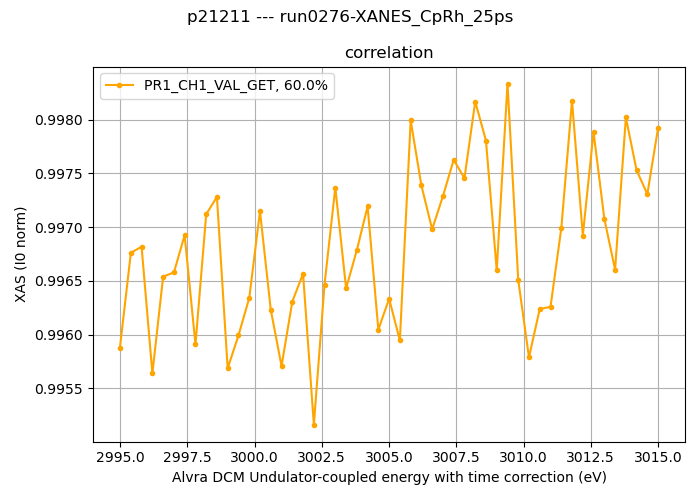

In [8]:
if not Two_diodes:
    detector_XAS_2 = detector_XAS_1
Plot_correlation(titlestring, scan, data, quantile_corr, detector_XAS_1, detector_XAS_2, timescan=False)

# Plot the run

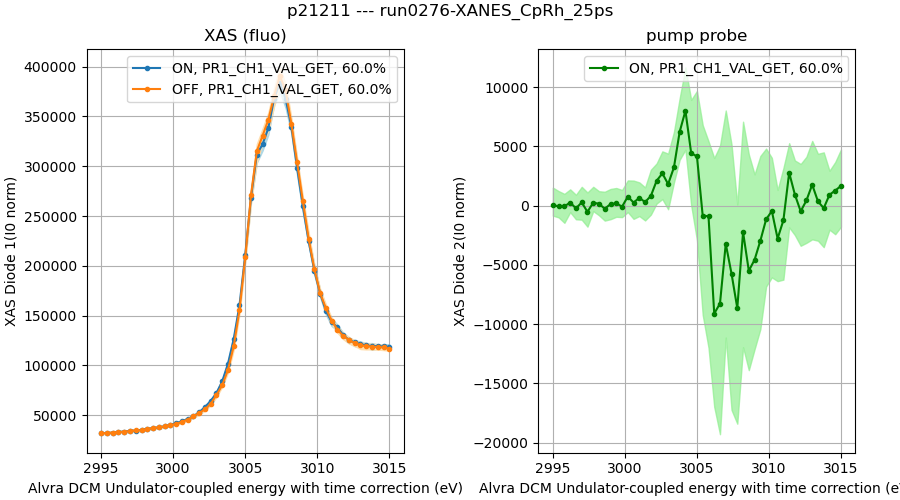

In [9]:
if Two_diodes:
    XAS1_pump_probe, XAS2_pump_probe, Energy_eV = Plot_2diodes_4figs(titlestring, scan, data, 
                                                              quantile_corr, detector_XAS_1, detector_XAS_2, timescan=False)
    XAS1_pump_probe, XAS2_pump_probe, Energy_eV = Plot_2diodes_2figs(titlestring, scan, data, 
                                                              quantile_corr, detector_XAS_1, detector_XAS_2, timescan=False)
    
    Energy_eV, ave_pp1 = Plot_2diodes_Averaged_2figs(titlestring, scan, data, timescan=False)
else:
    XAS1_pump_probe, Energy_eV = Plot_1diode(titlestring, scan, data, 
                                            quantile_corr, detector_XAS_1, timescan=False)

In [23]:
144.7665 - 142.283 + 6.51

8.99350000000002